Chenling: you have to run this in R to install the R packages

install.packages("idr")

source("https://bioconductor.org/biocLite.R")

biocLite("edgeR")

biocLite("DESeq2")

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/home/ec2-user/scVI/")
import sys
os.environ["PATH"] += os.pathsep + '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/R'
os.environ["R_HOME"] = '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/R'
os.getcwd()

'/home/ec2-user/scVI'

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [36]:
%matplotlib inline

In [4]:
from scvi.dataset.dataset10X import Dataset10X
from scvi.dataset.pbmc import PbmcDataset
import pandas as pd

from scvi.models.vae import VAE
from scvi.models.scanvi import SCANVI
from scvi.inference import UnsupervisedTrainer, SemiSupervisedTrainer, AlternateSemiSupervisedTrainer
from sklearn.metrics import roc_auc_score
from scvi.inference.posterior import get_bayes_factors
from scvi.inference.posterior import *
import numpy as np
from scvi.dataset.dataset import GeneExpressionDataset
import os
from scvi.metrics.clustering import select_indices_evenly

In [5]:
def auc_score_threshold(gene_set, bayes_factor, gene_symbols):
    # put ones on the genes from the gene_set
    true_labels = np.array([g in gene_set for g in gene_symbols])
    estimated_score = np.abs(bayes_factor)
    indices = np.isfinite(estimated_score)
    return roc_auc_score(true_labels[indices], estimated_score[indices])


def WeightedAccuracy(y,y_pred,cell_types):
    res = dict()
    for i in np.unique(y):
        res[cell_types[i]] = (np.mean(y_pred[y == i] == i), sum(y==i))
    return(res)



pbmc = PbmcDataset()
de_data  = pbmc.de_metadata
pbmc.update_cells(pbmc.batch_indices.ravel()==0)
# pbmc.labels = pbmc.labels.reshape(len(pbmc),1)

donor = Dataset10X('fresh_68k_pbmc_donor_a')
donor.gene_names = donor.gene_symbols
donor.labels = np.repeat(0,len(donor)).reshape(len(donor),1)
donor.cell_types = ['unlabelled']
all_dataset = GeneExpressionDataset.concat_datasets(pbmc, donor)

# Now resolve the Gene symbols to properly work with the DE
all_gene_symbols = donor.gene_symbols[
    np.array(
        [np.where(donor.gene_names == x)[0][0] for x in list(all_dataset.gene_names)]
    )]


#####################################################################
# Gene sets 1
############################################################################
path_geneset = "Additional_Scripts/genesets.txt"
geneset_matrix = np.loadtxt(path_geneset, dtype=np.str)[:, 2:]
CD4_TCELL_VS_BCELL_NAIVE, CD8_TCELL_VS_BCELL_NAIVE, CD8_VS_CD4_NAIVE_TCELL, NAIVE_CD8_TCELL_VS_NKCELL \
    = [set(geneset_matrix[i:i + 2, :].flatten()) & set(all_gene_symbols) for i in [0, 2, 4, 6]]

# these are the length of the positive gene sets for the DE
print((len(CD4_TCELL_VS_BCELL_NAIVE), len(CD8_TCELL_VS_BCELL_NAIVE),
       len(CD8_VS_CD4_NAIVE_TCELL), len(NAIVE_CD8_TCELL_VS_NKCELL)))

print(all_dataset.cell_types)

comparisons = [
    ['CD4 T cells', 'B cells'],
    ['CD8 T cells', 'B cells'],
    ['CD8 T cells', 'CD4 T cells'],
    ['CD8 T cells', 'NK cells']
               ]


gene_sets = [CD4_TCELL_VS_BCELL_NAIVE,
             CD8_TCELL_VS_BCELL_NAIVE,
             CD8_VS_CD4_NAIVE_TCELL,
             NAIVE_CD8_TCELL_VS_NKCELL]

#####################################################################
# Gene sets 2
############################################################################
print(de_data.columns.values)
CD = de_data['CD_adj.P.Val']
BDC = de_data['BDC_adj.P.Val']
BDC2 = de_data['BDC2_adj.P.Val']
CD = np.asarray(de_data['GS'][CD<0.05])
BDC = np.asarray(de_data['GS'][BDC<0.05])
BDC2 = np.asarray(de_data['GS'][BDC2<0.05])

gene_sets = [set(CD) & set(all_gene_symbols),
             set(BDC)& set(all_gene_symbols),
             set(BDC2) &  set(all_gene_symbols)]

comparisons = [
    ['CD8 T cells', 'CD4 T cells'],
    ['B cells', 'Dendritic Cells'],
    ['B cells', 'Dendritic Cells']
               ]


File data/gene_info_pbmc.csv already downloaded
File data/pbmc_metadata.pickle already downloaded
File data/10X/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 33694 to 21425 genes
Downsampling from 8381 to 8381 cells
File data/10X/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 33694 to 19773 genes
Downsampling from 4340 to 4340 cells
Keeping 19039 genes
Downsampling from 12721 to 11990 cells
Downsampling from 19039 to 19036 genes
Downsampling from 11990 to 11990 cells
Downsampling from 19036 to 3346 genes
Downsampling from 11990 to 11990 cells
Downsampling from 11990 to 7982 cells


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:536: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:604: RuntimeWarning: Degrees of freedom <= 0 for slice
  return N.ndarray.var(self, axis, dtype, out, ddof, keepdims=True)._collapse(axis)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:125: RuntimeWarning: i

File data/10X/fresh_68k_pbmc_donor_a/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Keeping 3343 genes
(145, 145, 137, 138)
['Other' 'Megakaryocytes' 'FCGR3A+ Monocytes' 'CD8 T cells'
 'CD14+ Monocytes' 'unlabelled' 'NK cells' 'Dendritic Cells' 'CD4 T cells'
 'B cells']
['Unnamed: 0' 'ENSG' 'GS' 'CD_logFC' 'CD_AveExpr' 'CD_t' 'CD_P.Value'
 'CD_adj.P.Val' 'CD_B' 'BDC_logFC' 'BDC_AveExpr' 'BDC_t' 'BDC_P.Value'
 'BDC_adj.P.Val' 'BDC_B' 'BDC2_logFC' 'BDC2_AveExpr' 'BDC2_t'
 'BDC2_P.Value' 'BDC2_adj.P.Val' 'BDC2_B']


In [6]:
vae = VAE(all_dataset.nb_genes, n_batch=all_dataset.n_batches, n_labels=all_dataset.n_labels,
          n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')

import torch
trainer = UnsupervisedTrainer(vae, all_dataset, train_size=1.0)
# trainer.train(n_epochs=200)
# torch.save(trainer.model,'../DE/vae.model.pkl')
trainer.model = torch.load('DE/vae.model.pkl')

trainer.train_set.entropy_batch_mixing()
full = trainer.create_posterior(trainer.model, all_dataset, indices=np.arange(len(all_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
keys = all_dataset.cell_types


from scvi.inference.posterior import entropy_batch_mixing
sample = select_indices_evenly(2000, batch_indices)
batch_entropy = entropy_batch_mixing(latent[sample, :], batch_indices[sample])


In [7]:
latent_labelled = latent[batch_indices.ravel()==0, :]
latent_unlabelled = latent[batch_indices.ravel()==1, :]
labels_labelled = labels[batch_indices.ravel()==0]
labels_unlabelled = labels[batch_indices.ravel()==1]
n_labels = np.sum(batch_indices.ravel()==1)
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh = neigh.fit(latent_labelled, labels_labelled)
vae_pred = neigh.predict(latent)
np.mean(vae_pred[batch_indices.ravel()==0]==labels[batch_indices.ravel()==0])

0.9625407166123778

## Code for running DE

In [8]:
from copy import deepcopy
batch2 = deepcopy(all_dataset)
batch2.update_cells(batch_indices.ravel()==1)
cell_type_label = \
    [[np.where(all_dataset.cell_types == x[i])[0].astype('int')[0] for i in [0, 1]] for x in comparisons]

Downsampling from 76561 to 68579 cells


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:536: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:604: RuntimeWarning: Degrees of freedom <= 0 for slice
  return N.ndarray.var(self, axis, dtype, out, ddof, keepdims=True)._collapse(axis)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:125: RuntimeWarning: i

In [9]:
from scipy.stats import kendalltau

import rpy2
from rpy2.robjects import r
import rpy2.robjects as robj
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
from rpy2.robjects.lib import grid
from rpy2.robjects import r, Formula
py2ri_orig = rpy2.robjects.conversion.py2ri
from rpy2.rinterface import RRuntimeWarning

r["library"]("idr")

def idr(bayes, p_value, p_prior=0.1):
    p_val_1r = r.matrix(bayes[:, np.newaxis], nrow=3343, ncol=1)
    r.assign("p_val_1", p_val_1r)

    p_val_2r = r.matrix(p_value[:, np.newaxis], nrow=3343, ncol=1)
    r.assign("p_val_2", p_val_2r)

    r("x <- cbind(p_val_1[, 1], p_val_2[, 1])")
    r("mu = 1")
    r("sigma = 0.5")
    r("rho = 0.5")
    r.assign("p", 0.25)
    return kendalltau(bayes, p_value)[0]

    r("idr.out <- est.IDR(x, mu, sigma, rho, p, eps=0.001, max.ite=20)")
    return r("idr.out$para$p")[0]

r["library"]("edgeR")

import pandas 
def conversion_pydataframe(obj):
    """
    Convert pandas DataFrame or python object to an R dataframe/object.
    """
    if isinstance(obj, pandas.core.frame.DataFrame):
        od = OrderedDict()
        for name, values in obj.iteritems():
            if values.dtype.kind == 'O':
                od[name] = rpy2.robjects.vectors.StrVector(values)
            else:
                od[name] = rpy2.robjects.conversion.py2ri(values)
        return rpy2.robjects.vectors.DataFrame(od)
    else:
        return py2ri_orig(obj)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: limma

  warnings.warn(x, RRuntimeWarning)


In [10]:
def run_edgeR(gene_expression, bio_assignment, gene_names, batch_info=None, batch=True):
    if batch_info is None:
        batch = False
    r_counts = conversion_pydataframe(gene_expression)
    r_bio_group = conversion_pydataframe(bio_assignment)
    r_dge = r.DGEList(counts=r.t(r_counts), genes=gene_names)
    r.assign("dge", r_dge)
    r.assign("bio_group", r.factor(r_bio_group))
    r("dge$samples$bio_group <- bio_group")

    if batch:
        r_batch_group = conversion_pydataframe(batch_info)
        r.assign("batch_group", r.factor(r_batch_group))
        r("dge$samples$batch_group <- batch_group")

    r("""dge <- suppressWarnings(edgeR::calcNormFactors(dge))""")
    
    if not batch:
        r("""design <- model.matrix(~bio_group, data = dge$samples)""")
        r("""colnames(design) <- c("Intercept", "bio")""")

    if batch:
        r("""design <- model.matrix(~bio_group+batch_group, data = dge$samples)""")
        r("""colnames(design) <- c("Intercept", "bio", "batch")""")

    r("""dge <- estimateDisp(dge, design)""")
    
    r("""fit <- glmFit(dge, design)""")
    if not batch:
        r("""lrt <- glmLRT(fit)""")
    if batch:
        r("""lrt <- glmLRT(fit, coef="bio")""")
    return r("lrt$table$PValue")

In [11]:
# sanity check, this should work and return some numbers
run_edgeR(all_dataset.X[:100].A, np.hstack((np.zeros(50), np.ones(50))), all_dataset.gene_names)
run_edgeR(all_dataset.X[:100].A, 
          np.hstack((np.zeros(50), np.ones(50))), 
          all_dataset.gene_names, 
          batch_info=np.hstack((np.zeros(20), np.ones(80))))

array([0.54443089, 0.67218622, 0.15043233, ..., 0.94562551, 0.81960669,
       0.35838388])

In [12]:
for t, comparison in enumerate(comparisons):
    print(t, comparison)

0 ['CD8 T cells', 'CD4 T cells']
1 ['B cells', 'Dendritic Cells']
2 ['B cells', 'Dendritic Cells']


In [13]:
interest_list = ["CD", "BDC"]
p_prior_list = [0.03, 0.25]
de_data.index = de_data["GS"]

## Running SCANVI

In [14]:
scanvi = SCANVI(all_dataset.nb_genes, all_dataset.n_batches, all_dataset.n_labels, n_layers=2)  
                                       #,classifier_parameters = {'dropout_rate':0.5, 'n_hidden':256, 'n_layers':2})
scanvi.load_state_dict(trainer.model.state_dict(), strict=False)
trainer_scanvi = SemiSupervisedTrainer(scanvi, all_dataset, classification_ratio=50,
                                        n_epochs_classifier=1, lr_classification=5 * 1e-3)
#trainer_scanvi = AlternateSemiSupervisedTrainer(scanvi, all_dataset, n_epochs_classifier=10, lr_classification=5 * 1e-3)

In [15]:
trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=(all_dataset.batch_indices == 0))
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=(all_dataset.batch_indices == 1))

In [16]:
trainer_scanvi.train(n_epochs=5)

training: 100%|██████████| 5/5 [03:24<00:00, 40.88s/it] 


In [17]:
# check for conformity between scVI and SCANVI + kNN
np.mean(trainer_scanvi.unlabelled_set.sequential().compute_predictions()[1] == neigh.predict(latent_unlabelled))

0.9152364426427915

In [18]:
trainer_scanvi.labelled_set.accuracy()

0.9898521673765973

In [19]:
de_posterior = trainer_scanvi.create_posterior(trainer_scanvi.model, all_dataset, indices=np.arange(0,len(all_dataset)))

In [20]:
de_posterior.get_regenerate_scale(1,5)

array([[1.5844224e-04, 2.1604316e-04, 1.9063588e-04, ..., 9.6071628e-05,
        1.7231374e-04, 8.3957496e-04],
       [1.3236134e-04, 2.1376499e-04, 1.3437915e-04, ..., 8.6953951e-05,
        1.0544689e-04, 7.3279755e-04],
       [1.3756900e-04, 1.9955589e-04, 1.6941081e-04, ..., 1.0360048e-04,
        1.3027480e-04, 8.4826705e-04],
       ...,
       [1.6281690e-04, 2.7903850e-04, 1.3986556e-04, ..., 1.0236438e-04,
        1.6243443e-04, 8.8155211e-04],
       [1.6903596e-04, 1.7018788e-04, 2.1255649e-04, ..., 8.7246532e-05,
        1.0700372e-04, 3.3576251e-04],
       [1.5374410e-04, 2.7940745e-04, 1.6159036e-04, ..., 8.3014289e-05,
        1.0733615e-04, 6.5302488e-04]], dtype=float32)

In [21]:
def reimpute(t, c, s, gamma):
    cell_idx = np.where(np.logical_and(vae_pred == cell_type_label[t][c], batch_indices.ravel() == s))[0]
    # REIMPUTE
    de_posterior = trainer_scanvi.create_posterior(trainer_scanvi.model, all_dataset, indices=cell_idx)
    # counterfactuals ?
    scale_info = de_posterior.get_regenerate_scale(gamma, int(cell_type_label[t][c]))
    return scale_info

In [22]:
def bayes_SCANVI(t, comparaison, T=1, n_perm = 10000):
    gene_set = gene_sets[t]
            
   
    res_scanvi = np.zeros((3, 2, T)) # 3 datasets, 2 metrics, T indep runs
    p_value = de_data[interest_list[t] + "_adj.P.Val"][all_gene_symbols].values
    p_prior = p_prior_list[t]

    for rep in range(T):
                
        #PBMC8K only
        type_A = reimpute(t, 0, 0, 0)
        type_B = reimpute(t, 1, 0, 0)
        scale_pbmc = np.concatenate((type_A, type_B), axis=0)
        local_labels = np.concatenate((np.ones(type_A.shape[0]), np.zeros(type_B.shape[0])))
        bayes_pbmc = get_bayes_factors(scale_pbmc,
                                       local_labels,
                                       0,
                                       1, m_permutation=n_perm)
            
        res_scanvi[0, 0, rep] = auc_score_threshold(gene_set, bayes_pbmc, all_gene_symbols)
        res_scanvi[0, 1, rep] = idr(np.abs(bayes_pbmc), -np.log(p_value), p_prior=p_prior)
        
        # PBMC68K only    
        type_A = reimpute(t, 0, 1, 1)
        type_B = reimpute(t, 1, 1, 1)
        questionable_scale_68k = np.concatenate((type_A, type_B), axis=0)
        local_labels = np.concatenate((np.ones(type_A.shape[0]), np.zeros(type_B.shape[0])))
        bayes_questionable = get_bayes_factors(questionable_scale_68k,
                                       local_labels,
                                       0,
                                       1, m_permutation=n_perm)
            
        res_scanvi[1, 0, rep] = auc_score_threshold(gene_set, bayes_questionable, all_gene_symbols)
        res_scanvi[1, 1, rep] = idr(np.abs(bayes_questionable), -np.log(p_value), p_prior=p_prior)
        
        #WHOLE PBMC
        
        #first all imputed pbmc
        type_A = np.concatenate((reimpute(t, 0, 0, 0), reimpute(t, 0, 0, 1)), axis=0)
        type_B = np.concatenate((reimpute(t, 1, 0, 1), reimpute(t, 1, 0, 1)), axis=0)
        scale_pbmc = np.concatenate((type_A, type_B), axis=0)
        local_labels = np.concatenate((np.ones(type_A.shape[0]), np.zeros(type_B.shape[0])))
        probs_all_imputed_pbmc = get_bayes_factors(scale_pbmc,
                                       local_labels,
                                       0,
                                       1,logit=False, m_permutation=n_perm)
        
        #second all imputed 68K
        type_A = np.concatenate((reimpute(t, 0, 1, 0), reimpute(t, 0, 1, 1)), axis=0)
        type_B = np.concatenate((reimpute(t, 1, 1, 1), reimpute(t, 1, 1, 1)), axis=0)
        scale_68k = np.concatenate((type_A, type_B), axis=0)
        local_labels = np.concatenate((np.ones(type_A.shape[0]), np.zeros(type_B.shape[0])))
        probs_all_imputed_68k = get_bayes_factors(scale_68k,
                                       local_labels,
                                       0,
                                       1,logit=False, m_permutation=n_perm)

        p_s = 0.5
        bayes_all_imputed = p_s * probs_all_imputed_pbmc + (1 - p_s) * probs_all_imputed_68k
        bayes_all_imputed = np.log(bayes_all_imputed + 1e-8) - np.log(1 - bayes_all_imputed + 1e-8)
        
        res_scanvi[2, 0, rep] = auc_score_threshold(gene_set, bayes_all_imputed, all_gene_symbols)
        res_scanvi[2, 1, rep] = idr(np.abs(bayes_all_imputed), -np.log(p_value), p_prior=p_prior)
            
    return res_scanvi


In [23]:
res_scanvi_CD = bayes_SCANVI(0, ['CD8 T cells', 'CD4 T cells'], T=10)

In [24]:
res_scanviBD = bayes_SCANVI(1, ['B cells', 'Dendritic Cells'], T=10)

In [25]:
res_scanvi_CD

array([[[0.75355677, 0.75404876, 0.75232891, 0.75562227, 0.75154006,
         0.75410172, 0.75579927, 0.75683759, 0.75839577, 0.75545363],
        [0.09392178, 0.09421277, 0.09381236, 0.09567076, 0.09388251,
         0.09480927, 0.09480127, 0.09621219, 0.09585765, 0.09619044]],

       [[0.75697975, 0.7557491 , 0.75576164, 0.75645014, 0.7553937 ,
         0.75576582, 0.75716233, 0.75563202, 0.75616024, 0.75899089],
        [0.08512385, 0.08497815, 0.08456746, 0.08445302, 0.08443489,
         0.08489169, 0.08492336, 0.08505568, 0.08450675, 0.0853447 ]],

       [[0.73406838, 0.73816871, 0.73419242, 0.73380357, 0.73359452,
         0.73828439, 0.73251578, 0.73297292, 0.73467326, 0.73352762],
        [0.05288846, 0.0542057 , 0.05311733, 0.05249796, 0.0525538 ,
         0.05469712, 0.05256633, 0.05267418, 0.05347152, 0.05259211]]])

In [26]:
res_scanviBD

array([[[0.74628628, 0.75127942, 0.74998152, 0.74784154, 0.75212127,
         0.74930323, 0.75155018, 0.75039829, 0.74763823, 0.74788589],
        [0.25951783, 0.26460955, 0.26342725, 0.26208448, 0.26624848,
         0.26156339, 0.26591456, 0.26486431, 0.26068286, 0.26091554]],

       [[0.62438397, 0.62341898, 0.62536629, 0.62661914, 0.6297784 ,
         0.62474252, 0.62585652, 0.62725353, 0.62002916, 0.62284396],
        [0.12905798, 0.12909999, 0.1302171 , 0.13192547, 0.1348509 ,
         0.13014945, 0.1314485 , 0.13267955, 0.12555571, 0.12833833]],

       [[0.70492291, 0.70508093, 0.70362362, 0.70450776, 0.70515486,
         0.70467017, 0.70498921, 0.70468541, 0.70358458, 0.70359313],
        [0.20179742, 0.20238917, 0.20096275, 0.20170444, 0.20265138,
         0.20193405, 0.20258573, 0.20224794, 0.20137356, 0.20110475]]])

# Analysis for DE in PBMCs

In [27]:
# trainer = UnsupervisedTrainer(vae, all_dataset, train_size=1.0)
# trainer.train(n_epochs=200)

In [28]:
def bayes(t, comparaison, T=1, n_perm = 10000):
    gene_set = gene_sets[t]
    
    cell_idx_8k = np.where(np.logical_or(
        all_dataset.labels.ravel() == cell_type_label[t][0],
        all_dataset.labels.ravel() == cell_type_label[t][1]))[0]
    
    cell_idx_68k = np.where(np.logical_or(
        vae_pred[batch_indices.ravel()==1] == cell_type_label[t][0],
        vae_pred[batch_indices.ravel()==1] == cell_type_label[t][1]))[0]
    
    cell_indices = np.where(np.logical_or(
        vae_pred == cell_type_label[t][0],
        vae_pred == cell_type_label[t][1]))[0]

    joint_de_posterior = trainer.create_posterior(trainer.model, all_dataset, indices=cell_indices)
    scale_pbmc = joint_de_posterior.sequential().get_harmonized_scale(0)
    scale_68k = joint_de_posterior.sequential().get_harmonized_scale(1)
    questionable_de_posterior = trainer.create_posterior(trainer.model, batch2, indices=cell_idx_68k)
    questionable_scale_68k = questionable_de_posterior.sequential().get_harmonized_scale(1)
    
    res_vi = np.zeros((3, 2, T)) # 3 datasets, 2 metrics, T indep runs
    res_eR = np.zeros((3, 2, T))
    p_value = de_data[interest_list[t] + "_adj.P.Val"][all_gene_symbols].values
    p_prior = p_prior_list[t]

    for rep in range(T):
        
        #PBMC8K only
        bayes_pbmc = get_bayes_factors(scale_pbmc,
                                       all_dataset.labels.ravel()[cell_indices],
                                       cell_type_label[t][0],
                                       cell_type_label[t][1], m_permutation=n_perm)
            
        res_vi[0, 0, rep] = auc_score_threshold(gene_set, bayes_pbmc, all_gene_symbols)
        res_vi[0, 1, rep] = idr(np.abs(bayes_pbmc), -np.log(p_value), p_prior=p_prior)
        
        ind_0 = np.random.choice(np.where(all_dataset.labels.ravel() == cell_type_label[t][0])[0], 100)
        ind_1 = np.random.choice(np.where(all_dataset.labels.ravel() == cell_type_label[t][1])[0], 100)
        expression_data = np.vstack((all_dataset.X[ind_0].A, all_dataset.X[ind_1].A))
        bio_data = np.hstack((all_dataset.labels.ravel()[ind_0], all_dataset.labels.ravel()[ind_1]))
        edgeR_pbmc = run_edgeR(expression_data, bio_data, all_dataset.gene_names)
        
        res_eR[0, 0, rep] = auc_score_threshold(gene_set, -np.log(edgeR_pbmc), all_gene_symbols)
        res_eR[0, 1, rep] = idr(-np.log(edgeR_pbmc), -np.log(p_value), p_prior=p_prior)
        
        # PBMC68K only        
        bayes_questionable = get_bayes_factors(questionable_scale_68k,
                                       vae_pred[batch_indices.ravel()==1][cell_idx_68k],
                                       cell_type_label[t][0],
                                       cell_type_label[t][1], logit=True, m_permutation=n_perm)
        
        res_vi[1, 0, rep] = auc_score_threshold(gene_set, bayes_questionable, all_gene_symbols)
        res_vi[1, 1, rep] = idr(np.abs(bayes_questionable), -np.log(p_value), p_prior=p_prior)
        
        ind_0 = np.random.choice(np.where(vae_pred[batch_indices.ravel()==1] == cell_type_label[t][0])[0], 100)
        ind_1 = np.random.choice(np.where(vae_pred[batch_indices.ravel()==1] == cell_type_label[t][1])[0], 100)
        expression_data = np.vstack((all_dataset.X[batch_indices.ravel()==1][ind_0].A, 
                                     all_dataset.X[batch_indices.ravel()==1][ind_1].A))
        bio_data = np.hstack((vae_pred[batch_indices.ravel()==1][ind_0], 
                                vae_pred[batch_indices.ravel()==1][ind_1]))
        edgeR_68k = run_edgeR(expression_data, bio_data, all_dataset.gene_names)
        
        
        res_eR[1, 0, rep] = auc_score_threshold(gene_set, -np.log(edgeR_68k), all_gene_symbols)
        res_eR[1, 1, rep] = idr(-np.log(edgeR_68k), -np.log(p_value), p_prior=p_prior)
        
        
        #WHOLE PBMC
        probs_all_imputed_pbmc = get_bayes_factors(scale_pbmc,
                                                   vae_pred[cell_indices],
                                                   cell_type_label[t][0],
                                                   cell_type_label[t][1], logit=False, m_permutation=n_perm)
        probs_all_imputed_68k = get_bayes_factors(scale_68k,
                                                  vae_pred[cell_indices],
                                                  cell_type_label[t][0],
                                                  cell_type_label[t][1], logit=False, m_permutation=n_perm)

        p_s = 0.5
        bayes_all_imputed = p_s * probs_all_imputed_pbmc + (1 - p_s) * probs_all_imputed_68k
        bayes_all_imputed = np.log(bayes_all_imputed + 1e-8) - np.log(1 - bayes_all_imputed + 1e-8)
        
        res_vi[2, 0, rep] = auc_score_threshold(gene_set, bayes_all_imputed, all_gene_symbols)
        res_vi[2, 1, rep] = idr(np.abs(bayes_all_imputed), -np.log(p_value), p_prior=p_prior)
        
        
        
        ind_0 = np.random.choice(np.where(vae_pred == cell_type_label[t][0])[0], 100)
        ind_1 = np.random.choice(np.where(vae_pred == cell_type_label[t][1])[0], 100)
        expression_data = np.vstack((all_dataset.X[ind_0].A, 
                                     all_dataset.X[ind_1].A))
        bio_data = np.hstack((vae_pred[ind_0], 
                                vae_pred[ind_1]))
        batch_data = np.hstack((batch_indices.ravel()[ind_0], 
                                batch_indices.ravel()[ind_1]))
        edgeR_all = run_edgeR(expression_data, bio_data, all_dataset.gene_names, batch_info=batch_data)
        
        res_eR[2, 0, rep] = auc_score_threshold(gene_set, -np.log(edgeR_all), all_gene_symbols)
        res_eR[2, 1, rep] = idr(-np.log(edgeR_all), -np.log(p_value), p_prior=p_prior)
            
    return res_vi, res_eR


In [29]:
# res_vi_CD, res_eR_CD = bayes(0, ['CD8 T cells', 'CD4 T cells'], T=10)

In [30]:
res_vi_CD = np.zeros(shape=(3, 2, 20))
res_vi_CD[:, :, 0:10] = np.array([[[0.74179377, 0.74341328, 0.74160423, 0.74092827, 0.74140632,
         0.74038472, 0.74296032, 0.74308575, 0.74411432, 0.74314708],
        [0.08750865, 0.08894623, 0.08789463, 0.08762385, 0.08780319,
         0.08762654, 0.08826396, 0.08900238, 0.08873346, 0.08811804]],

       [[0.74675263, 0.74551083, 0.74674288, 0.74913868, 0.74716935,
         0.74822022, 0.74852684, 0.74792196, 0.74713312, 0.74715402],
        [0.08048591, 0.08033702, 0.08046566, 0.08046593, 0.08016567,
         0.08051044, 0.08016824, 0.07980553, 0.08121617, 0.08056803]],

       [[0.76197345, 0.76349121, 0.76386194, 0.76282362, 0.76226056,
         0.76212258, 0.76225777, 0.76212816, 0.7634271 , 0.76225917],
        [0.09586819, 0.09568671, 0.09580298, 0.09603906, 0.09650841,
         0.09511547, 0.09542531, 0.09559493, 0.09614803, 0.09609681]]])

res_vi_CD[:, :, 10:20] = np.array([[[0.75417419, 0.75457558, 0.75468848, 0.75278605, 0.75332542,
         0.75416165, 0.75286967, 0.75245155, 0.75249058, 0.75410033],
        [0.09158216, 0.09102047, 0.09207042, 0.09157896, 0.09150232,
         0.09132688, 0.09088955, 0.0913412 , 0.09111706, 0.09173033]],

       [[0.79908962, 0.79865199, 0.79874398, 0.79935025, 0.80011819,
         0.79805966, 0.79902551, 0.79841924, 0.79771541, 0.79759416],
        [0.09859252, 0.09773535, 0.0975626 , 0.0980051 , 0.09800814,
         0.0964899 , 0.09836047, 0.09763968, 0.09819487, 0.09751467]],

       [[0.79269941, 0.79350777, 0.79318582, 0.79333077, 0.79405968,
         0.79299488, 0.79301439, 0.79338931, 0.7933015 , 0.79138235],
        [0.10209858, 0.10273243, 0.10230053, 0.10252938, 0.10292382,
         0.10213497, 0.10260402, 0.10224322, 0.10237377, 0.10181907]]])

res_scanvi_CD = np.zeros(shape=(3, 2, 20))

res_scanvi_CD[:, :, :10] = np.array([[[0.73591227, 0.74181607, 0.74102305, 0.73939657, 0.7415429 ,
         0.74234429, 0.74275126, 0.74165301, 0.74082653, 0.73958055],
        [0.08576389, 0.08914505, 0.08794416, 0.0883914 , 0.08934365,
         0.08863148, 0.08805632, 0.08908045, 0.08863834, 0.08748389]],

       [[0.73813247, 0.73829135, 0.73999866, 0.7371262 , 0.73926138,
         0.73710669, 0.73958194, 0.73939379, 0.73613806, 0.73713596],
        [0.08108458, 0.08152833, 0.08175576, 0.08071192, 0.0820627 ,
         0.08104455, 0.08215112, 0.08162892, 0.08114707, 0.0809839 ]],

       [[0.73731714, 0.73618823, 0.7361283 , 0.73251717, 0.73472064,
         0.7323987 , 0.73572412, 0.7329994 , 0.73235132, 0.73477918],
        [0.05325123, 0.05274954, 0.0528162 , 0.05147266, 0.05318291,
         0.0514511 , 0.05263902, 0.05149933, 0.0517519 , 0.05266503]]])

res_scanvi_CD[:, :, 10:20] = np.array([[[0.72642243, 0.72194719, 0.72290886, 0.72434997, 0.72413952,
         0.72289911, 0.72474718, 0.72087124, 0.72483638, 0.72704403],
        [0.08455153, 0.08383432, 0.08644679, 0.08488945, 0.085161  ,
         0.08583689, 0.08629802, 0.0857071 , 0.086799  , 0.08682616]],

       [[0.71818554, 0.72028588, 0.7213256 , 0.71729217, 0.71859808,
         0.71968379, 0.71805175, 0.71740088, 0.7206371 , 0.72063292],
        [0.0764584 , 0.0765634 , 0.07685212, 0.07651119, 0.07691423,
         0.07666002, 0.07657037, 0.07576228, 0.07721007, 0.07710098]],

       [[0.73986765, 0.73857289, 0.73862724, 0.74205997, 0.74187879,
         0.73936034, 0.74235544, 0.73938264, 0.7399903 , 0.73793456],
        [0.05429242, 0.05423416, 0.05436585, 0.05527159, 0.05515136,
         0.05405697, 0.05595232, 0.05381156, 0.05469455, 0.05400319]]])


res_eR_CD = np.array([[[ 0.76960686,  0.71892282,  0.72494648,  0.75238605,
          0.76890024,  0.70751661,  0.75340625,  0.74500072,
          0.73596245,  0.70655913],
        [ 0.04291846,  0.00267855,  0.03567862,  0.0423587 ,
          0.03815828,  0.02030369,  0.06091144,  0.03342154,
          0.03137338,  0.03229609]],

       [[ 0.64782078,  0.63272121,  0.61034782,  0.59525801,
          0.62588501,  0.61103631,  0.63377905,  0.60779591,
          0.60141128,  0.62892611],
        [-0.00643908, -0.02246596, -0.00749381,  0.00080053,
         -0.00311443, -0.0044296 ,  0.01644145,  0.00226646,
         -0.02082449,  0.00244452]],

       [[ 0.65886323,  0.67516   ,  0.67036699,  0.66198934,
          0.63316999,  0.64692601,  0.65000753,  0.63855951,
          0.63738739,  0.66806596],
        [ 0.01081833,  0.00459823, -0.00159639,  0.01723901,
          0.0048482 ,  0.00922013,  0.00262937, -0.00441655,
          0.01479358,  0.01156533]]])

In [31]:
# res_viBD, res_eRBD = bayes(1, ['B cells', 'Dendritic Cells'], T=10)

In [32]:
res_viBD = np.zeros(shape=(3, 2, 20))
res_viBD[:, :, 0:10] = np.array([[[0.76216623, 0.7621787 , 0.76190101, 0.76309841, 0.76293924,
         0.7629658 , 0.76238431, 0.76258438, 0.76264306, 0.7626761 ],
        [0.27079867, 0.27089967, 0.27083262, 0.27195724, 0.27135307,
         0.27161809, 0.27123275, 0.27124604, 0.27110905, 0.27136024]],

       [[0.6647708 , 0.66397908, 0.66641847, 0.66500968, 0.66508222,
         0.66401142, 0.66490156, 0.6627357 , 0.66476641, 0.66393403],
        [0.17887529, 0.17828975, 0.18058998, 0.17899893, 0.17895525,
         0.17814105, 0.17894282, 0.17672005, 0.17928901, 0.17828845]],

       [[0.73260152, 0.73267499, 0.73358615, 0.73319918, 0.73316546,
         0.73398051, 0.73346186, 0.73343437, 0.7333542 , 0.73397912],
        [0.2442582 , 0.24450203, 0.24486564, 0.24488628, 0.24457159,
         0.24527592, 0.24504063, 0.2447643 , 0.24495298, 0.24537476]]])

res_viBD[:, :, 10:20] = np.array([[[0.75488502, 0.75374653, 0.75411455, 0.75401729, 0.75406719,
         0.75420996, 0.75399627, 0.75460894, 0.75443475, 0.75364973],
        [0.2638777 , 0.26282807, 0.26325461, 0.26283149, 0.2631392 ,
         0.26339292, 0.26314752, 0.26362337, 0.26330234, 0.2628288 ]],

       [[0.65061453, 0.650344  , 0.65092572, 0.65210856, 0.65120918,
         0.6511579 , 0.65051103, 0.6497193 , 0.64993115, 0.65079588],
        [0.15986153, 0.15937252, 0.16013605, 0.16154904, 0.160391  ,
         0.16011636, 0.15967454, 0.15909964, 0.15904088, 0.15983152]],

       [[0.7162087 , 0.71617104, 0.71592916, 0.71521645, 0.71573926,
         0.71538278, 0.71668923, 0.71594856, 0.71633877, 0.71671949],
        [0.23016267, 0.23022916, 0.229731  , 0.2291882 , 0.2297717 ,
         0.22934815, 0.23083626, 0.23023846, 0.23039364, 0.23059034]]])

res_scanviBD = np.zeros(shape=(3, 2, 20))

res_scanviBD[:, :, 0:10] = np.array([[[0.75741636, 0.75759194, 0.75530756, 0.75769798, 0.75687253,
         0.75750345, 0.75652114, 0.75726688, 0.75536116, 0.75609097],
        [0.26981428, 0.26968712, 0.26795401, 0.26931847, 0.26893219,
         0.26969672, 0.26857317, 0.26922094, 0.26761619, 0.26827264]],

       [[0.61778868, 0.61487407, 0.61268003, 0.61774986, 0.61310765,
         0.61494823, 0.61750544, 0.61525688, 0.61407726, 0.61757244],
        [0.12643376, 0.12426852, 0.12215373, 0.12657811, 0.12234908,
         0.12382592, 0.12636433, 0.12479465, 0.12327429, 0.12611727]],

       [[0.70791976, 0.70693767, 0.70634787, 0.70565133, 0.70654147,
         0.70728075, 0.70637213, 0.70708992, 0.7073988 , 0.70590476],
        [0.21001276, 0.20899559, 0.2084635 , 0.20813155, 0.20902723,
         0.20955855, 0.20845892, 0.20910832, 0.20938078, 0.20817102]]])

res_scanviBD[:, :, 10:20] = np.array([[[0.76208953, 0.76043308, 0.76239402, 0.76090783, 0.76078608,
         0.76331119, 0.76113239, 0.76129134, 0.76086995, 0.76251323],
        [0.27278669, 0.27165384, 0.27267647, 0.27240443, 0.27141383,
         0.27418495, 0.27250955, 0.27185519, 0.27196155, 0.27315013]],

       [[0.62128293, 0.62249188, 0.62497008, 0.62396281, 0.62468315,
         0.62209244, 0.6229671 , 0.62243921, 0.62077675, 0.61347822],
        [0.1311073 , 0.13233849, 0.13501059, 0.13417064, 0.13440472,
         0.13212217, 0.13216301, 0.13185219, 0.13153761, 0.12328159]],

       [[0.71552325, 0.71486182, 0.71476133, 0.71533704, 0.71545486,
         0.71520282, 0.71598923, 0.71492975, 0.71560595, 0.7149205 ],
        [0.21705476, 0.21682827, 0.21658671, 0.2171116 , 0.21707235,
         0.21699594, 0.21809479, 0.21661098, 0.21735403, 0.21699208]]])


res_eRBD = np.array([[[0.7416328 , 0.74108303, 0.7507067 , 0.75045367, 0.7474157 ,
         0.73776104, 0.7328043 , 0.7499224 , 0.72650216, 0.73513615],
        [0.24713109, 0.25346313, 0.25564169, 0.26018451, 0.25280303,
         0.24126276, 0.24769716, 0.25299663, 0.23575936, 0.24152132]],

       [[0.70013099, 0.68185462, 0.70254589, 0.69692252, 0.68672046,
         0.69266935, 0.68556026, 0.69962944, 0.67819704, 0.68147574],
        [0.20929109, 0.18102042, 0.20679624, 0.19731936, 0.20039674,
         0.19525754, 0.1890307 , 0.21515119, 0.19126713, 0.17762601]],

       [[0.71723514, 0.70821316, 0.70168463, 0.72272244, 0.72508906,
         0.73544405, 0.70920518, 0.71120539, 0.72057794, 0.72148184],
        [0.22764441, 0.21764863, 0.21054128, 0.2284016 , 0.21516779,
         0.23869439, 0.2199275 , 0.22334562, 0.23646588, 0.23779653]]])

In [33]:
res_vi_CD.shape

(3, 2, 20)

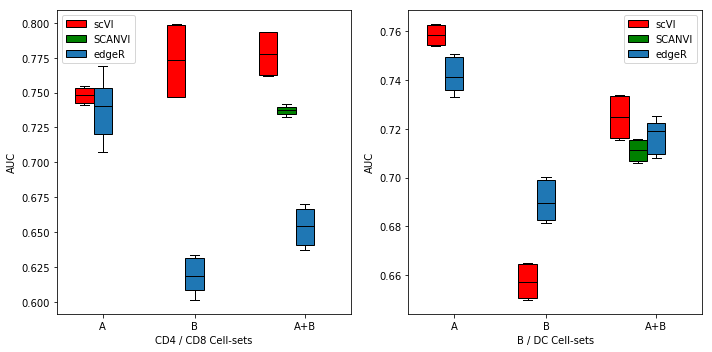

In [37]:
plt.figure(figsize=(10, 5))
props = dict(widths=0.2, patch_artist=True, medianprops=dict(color="black"), whis=[5, 95], sym="")

#AUC CD$CD*
ax = plt.subplot(1, 2, 1)
ax.set_ylabel("AUC")
ax.set_xlabel("CD4 / CD8 Cell-sets")


bp1 = ax.boxplot([np.array(res_vi_CD)[i, 0] for i in range(3)], positions=[0, 1, 2], **props)
bp2 = ax.boxplot([np.array(res_scanvi_CD)[i, 0] for i in [2]], positions=[2.2], **props)
bp3 = ax.boxplot([np.array(res_eR_CD)[i, 0] for i in range(3)], positions=[0.2, 1.2, 2.4], **props)

for patch in bp1['boxes']:
    patch.set_facecolor('red')
for patch in bp2['boxes']:
    patch.set_facecolor('green')
    
ax.set_xticklabels(['A','B', 'A+B'])
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['scVI', 'SCANVI', 'edgeR'])

# AUC BDC
ax = plt.subplot(1, 2, 2)
ax.set_ylabel("AUC")
ax.set_xlabel("B / DC Cell-sets")

bp1 = ax.boxplot([np.array(res_viBD)[i, 0] for i in range(3)], positions=[0, 1, 2], **props)
bp2 = ax.boxplot([np.array(res_scanviBD)[i, 0] for i in [2]], positions=[2.2], **props)
bp3 = ax.boxplot([np.array(res_eRBD)[i, 0] for i in range(3)], positions=[0.2, 1.2, 2.4], **props)

for patch in bp1['boxes']:
    patch.set_facecolor('red')
for patch in bp2['boxes']:
    patch.set_facecolor('green')
    
ax.set_xticklabels(['A','B', 'A+B'])
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['scVI', 'SCANVI', 'edgeR'])

plt.tight_layout()
plt.savefig("figures/DE_panel_1.pdf", transparency=True)

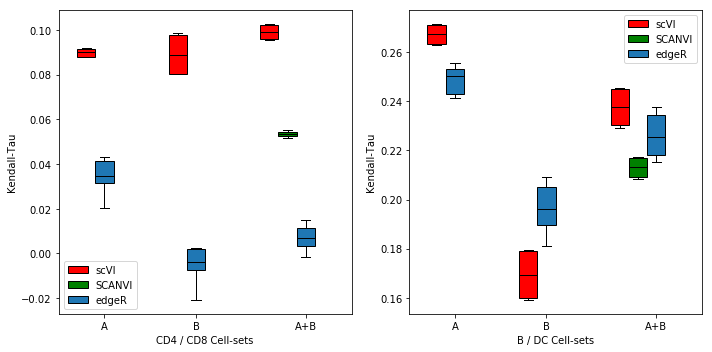

In [38]:
plt.figure(figsize=(10, 5))
props = dict(widths=0.2, patch_artist=True, medianprops=dict(color="black"), whis=[5, 95], sym="")

#AUC CD$CD*
ax = plt.subplot(1, 2, 1)
ax.set_ylabel("Kendall-Tau")
ax.set_xlabel("CD4 / CD8 Cell-sets")

bp1 = ax.boxplot([np.array(res_vi_CD)[i, 1] for i in range(3)], positions=[0, 1, 2], **props)
bp2 = ax.boxplot([np.array(res_scanvi_CD)[i, 1] for i in [2]], positions=[2.2], **props)
bp3 = ax.boxplot([np.array(res_eR_CD)[i, 1] for i in range(3)], positions=[0.2, 1.2, 2.4], **props)

for patch in bp1['boxes']:
    patch.set_facecolor('red')
for patch in bp2['boxes']:
    patch.set_facecolor('green')
    
ax.set_xticklabels(['A','B', 'A+B'])
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['scVI', 'SCANVI', 'edgeR'])


# AUC BDC
ax = plt.subplot(1, 2, 2)
ax.set_ylabel("Kendall-Tau")
ax.set_xlabel("B / DC Cell-sets")


bp1 = ax.boxplot([np.array(res_viBD)[i, 1] for i in range(3)], positions=[0, 1, 2], **props)
bp2 = ax.boxplot([np.array(res_scanviBD)[i, 1] for i in [2]], positions=[2.2], **props)
bp3 = ax.boxplot([np.array(res_eRBD)[i, 1] for i in range(3)], positions=[0.2, 1.2, 2.4], **props)

for patch in bp1['boxes']:
    patch.set_facecolor('red')
for patch in bp2['boxes']:
    patch.set_facecolor('green')
    
ax.set_xticklabels(['A','B', 'A+B'])
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['scVI', 'SCANVI', 'edgeR'])

plt.tight_layout()
plt.savefig("figures/DE_panel_2.pdf", transparency=True)
